# Курсовая. Экспериментальная часть

### Здесь приведены все операции, который я выполнял, чтобы получить результаты, приведённые в документе. Я также применял анализ отзывов по темам с помощью LDA, но он не дал осмысленных результатов.

Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
from scipy import stats
from statsmodels.stats import proportion

In [2]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings 
warnings.filterwarnings('ignore')

In [4]:
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
df = pd.read_excel('finalAll.xlsx')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9624 entries, 0 to 9623
Data columns (total 21 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   отзыв                                                                         9624 non-null   object 
 1   Разметка отзыва (п - положительный, н - нейтральный, о - отрицательный)       9623 non-null   object 
 2   ответ психолога на отзыв                                                      5229 non-null   object 
 3   ссылка на профиль
                                                            9624 non-null   object 
 4   пол (м или ж)                                                                 9624 non-null   object 
 5   возраст                                                                       8355 non-null   float64
 6   опыт работы психологом (количест

Преобразуем в числа стоимость консультации

In [9]:
df[df.columns[17]] = pd.to_numeric(df[df.columns[17]])

Найдём связь между ценой и долей негативных отзывов

In [10]:
df['is_negative'] = df[df.columns[1]].apply(lambda x: 1 if x == 'о' else 0)

In [15]:
id_negative_age = df.groupby(df.columns[3]).mean()[[df.columns[17], 'is_negative']].dropna()

In [22]:
res = stats.pearsonr(id_negative_age.iloc[:, 0], id_negative_age.iloc[:, 1])
print(f'Correlation between price and proportion of negative reviews\nr Pearson = {res[0]:.3f}, p-value = {res[1]:.3f}')

Correlation between price and proportion of negative reviews
r Pearson = 0.125, p-value = 0.033


Но не было найдено аналогичной связи между долей негативных отзывов и (возрастом, опытом работы)

Распределение психологов по полу в абсолютных значениях и в процентах

In [25]:
sex_psychologists = df.groupby([df.columns[3], df.columns[4]]).mean().reset_index()[df.columns[4]]
sex_psychologists.value_counts()

ж    214
м     86
Name: пол (м или ж), dtype: int64

In [26]:
sex_psychologists.value_counts(normalize=True).round(2)

ж    0.71
м    0.29
Name: пол (м или ж), dtype: float64

Ниже процентное и абсолютное соотношение негативных отзывов, где 1 - негативные отзывы.

Психологи мужского пола

In [31]:
male_psychologists = df[df[df.columns[4]] == 'м']['is_negative']
male_psychologists.value_counts(normalize=True).round(3)

0    0.977
1    0.023
Name: is_negative, dtype: float64

In [32]:
male_psychologists.value_counts()

0    3000
1      70
Name: is_negative, dtype: int64

Психологи женского пола

In [33]:
female_psychologists = df[df[df.columns[4]] == 'ж']['is_negative']
female_psychologists.value_counts(normalize=True).round(3)

0    0.982
1    0.018
Name: is_negative, dtype: float64

In [34]:
female_psychologists.value_counts()

0    6438
1     116
Name: is_negative, dtype: int64

Видим разницу в соотношении отзывов, но она небольшая (.023 vs .018), поэтому даже не стоит рассматривать статистические тесты.

In [35]:
# proportion.proportions_ztest(np.array([3000, 6438]), np.array([3000 + 70, 6438 + 116]), alternative='two-sided')

Соотношение отзывов без деления по полу психолога

In [36]:
(df[df.columns[1]] == 'о').value_counts()

False    9438
True      186
Name: Разметка отзыва (п - положительный, н - нейтральный, о - отрицательный), dtype: int64

In [37]:
df[df.columns[1]].value_counts()

п    8878
н     559
о     186
Name: Разметка отзыва (п - положительный, н - нейтральный, о - отрицательный), dtype: int64

На ~51 положительный или нейтральный отзыв приходится один отрицательный

In [39]:
(8878 + 559) / 186

50.736559139784944

Функция процессинга текста имеет такой вид, так как под windows лемматизация при помощи pymystem3 выполняется неадекватно долго и необходимы обходные пути, чтобы ускорить функцию, оставив прежний функционал.

In [40]:
def preprocess_text(texts):
    russian_stopwords = stopwords.words("russian")
    mystem = Mystem() 
    lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]
    txtpart = lol(texts, 1000)
    res = []
    for txtp in txtpart:
        alltexts = ' '.join([txt + ' br ' for txt in txtp])

        words = mystem.lemmatize(alltexts)
        doc = []
        for txt in words:
            if txt != '\n' and txt.strip() != ''\
            and txt not in russian_stopwords and all(i not in punctuation for i in txt) and len(txt) > 1 and not any(char.isdigit() for char in txt):
                if txt == 'br':
                    res.append(doc)
                    doc = []
                else:
                    doc.append(txt)
    return res

In [41]:
%%time
reviews_processed = preprocess_text(df['отзыв'])

Wall time: 45.5 s


In [42]:
def get_freq_words(reviews_processed, sentiment, condition=None):
    """
    Функция принимает таблицу с почищенными отзывами, тип отзыва и опционально дополнительное условие.
    Выводит отсортированные частоты слов в формате pd.Series"""
    blank = []
    if condition is not None:
        [blank.extend(i) for i in pd.Series(reviews_processed)[(df[df.columns[1]] == sentiment) & condition]]
    else:
        [blank.extend(i) for i in pd.Series(reviews_processed)[df[df.columns[1]] == sentiment]]
    return pd.Series(blank).value_counts(normalize=True)

Ниже нахожу частоты слов в отрицательных и положительных отзывах

In [43]:
pos = get_freq_words(reviews_processed, 'п')
neg = get_freq_words(reviews_processed, 'о')

Нахожу частоты положительных отзывов у психологов в зависимости от пола

In [67]:
pos_male = get_freq_words(reviews_processed, 'п', df[df.columns[4]] == 'м')
pos_female = get_freq_words(reviews_processed, 'п', df[df.columns[4]] == 'ж')

Ниже цикл находит слова, которые встречаются у психологов обоих полов. И записывает у этого слова соотношение частот (== шансы).

In [68]:
multi_freq_sex = {}
for i in pos_female.index:
    if i in pos_male.index:
        multi_freq_sex[i] = pos_female[i] / pos_male[i]
multi_freq_sex = pd.Series(multi_freq_sex).sort_values()

Находим шансы, записываем в словарь и выводим в текстовый файл

In [79]:
dict_sex_psychologists = {}
min_in_male = 10
min_multiplicator = 1.5
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    for i in multi_freq_sex[:].index:
        odds = 1 / multi_freq_sex[i]
        if odds < min_multiplicator:
#         прерываем цикл, если встретилось слово с шансами, ниже указанного
            break
        if pos_male[i] / pos_male.min() >= min_in_male:
            dict_sex_psychologists[i] = (odds).round(2)

In [80]:
dict_sex_psychologists_reverse = {}
min_in_male = 10
min_multiplicator = 1.5
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    for i in multi_freq_sex[::-1].index:
        odds = multi_freq_sex[i]
        if odds < min_multiplicator:
#         прерываем цикл, если встретилось слово с шансами, ниже указанного
            break
        if pos_male[i] / pos_male.min() >= min_in_male:
            dict_sex_psychologists_reverse[i] = (odds).round(2)

In [81]:
with open('txt_out/sex_psychologists.txt', 'w') as f:
    for k, v in dict_sex_psychologists.items():
        f.write(str(k) + ' '+ str(v) + '\n')
with open('txt_out/sex_psychologists_reverse.txt', 'w') as f:
    for k, v in dict_sex_psychologists_reverse.items():
        f.write(str(k) + ' '+ str(v) + '\n')

Далее операции аналогичные, но находим шансы слов уже между отрицательными и положительными отзывами

## переписать с двумя или даже тремя функциями

In [50]:
multi_freq = {}
for i in neg.index:
    if i in pos.index:
        multi_freq[i] = pos[i] / neg[i]
multi_freq = pd.Series(multi_freq).sort_values()

In [79]:
dict_sentiments = {}
min_in_neg = 4
min_multiplicator = 2
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    for i in multi_freq[:].index:
        odds = 1 / multi_freq[i]
        if odds < min_multiplicator:
#         прерываем цикл, если встретилось слово с шансами, ниже указанного
            break
        if neg[i] / neg.min() >= min_in_neg:
            dict_sentiments[i] = (odds).round(2)

In [79]:
dict_sentiments_reverse = {}
min_in_neg = 4
min_multiplicator = 2
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    for i in multi_freq[:].index:
        odds = multi_freq[i]
        if odds < min_multiplicator:
#         прерываем цикл, если встретилось слово с шансами, ниже указанного
            break
        if neg[i] / neg.min() >= min_in_neg:
            dict_sentiments_reverse[i] = (odds).round(2)

In [80]:
dict_sex_psychologists_reverse = {}
min_in_male = 10
min_multiplicator = 1.5
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    for i in multi_freq_sex[::-1].index:
        odds = multi_freq_sex[i]
        if odds < min_multiplicator:
#         прерываем цикл, если встретилось слово с шансами, ниже указанного
            break
        if pos_male[i] / pos_male.min() >= min_in_male:
            dict_sex_psychologists_reverse[i] = (odds).round(2)

In [81]:
with open('txt_out/sex_psychologists.txt', 'w') as f:
    for k, v in dict_sex_psychologists.items():
        f.write(str(k) + ' '+ str(v) + '\n')
with open('txt_out/sex_psychologists_reverse.txt', 'w') as f:
    for k, v in dict_sex_psychologists_reverse.items():
        f.write(str(k) + ' '+ str(v) + '\n')

In [82]:
# min_in_neg = 4
# min_multiplicator = 2
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     for i in multi_freq[:].index:
#         if neg[i] / neg.min() >= min_in_neg:
#             print(i, (1 / multi_freq[i]).round(4))
#         if 1 / multi_freq[i] < min_multiplicator:
#             break

In [83]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
# #     print(multi_freq[:50])
#     for i in multi_freq[-200:].index:
# #         print(neg[i] / neg[i].min())
#         if neg[i] / neg.min() > 4:
#             print(i, multi_freq[i].round(4))

In [84]:
rev_neg = pd.Series(reviews_processed)[df[df.columns[1]] == 'о']
rev_pos = pd.Series(reviews_processed)[df[df.columns[1]] == 'п']

In [118]:
rev_pos[rev_pos.apply(lambda x: 'черепаха' in x)]

17      [здравствовать, оксана, впечатление, работа, о...
9103    [древность, человек, верить, земля, держаться,...
dtype: object

Не очень удобно, но оригинальные отзывы можно прямо здесь почитать.

In [119]:
ix = rev_pos[rev_pos.apply(lambda x: 'черепаха' in x)].index
with pd.option_context('display.max_colwidth', None):
    print(df.iloc[ix, 0])

17      Здравствуйте, Оксана!Впечатления от работы с Вами у меня очень хорошие. С Вами легко и весело, а это для любого серьезного дела несомненный плюс.Самое ценное, что я вынесла из консультации - ясное осознание своих эмоций (которые Вы так четко озвучили), суть моего сопротивления, и что нужно все-таки принимать себя, без этого никак. Что нужно искать в себе цветные краски, а не зацикливаться только на черном. Сейчас вот именно это и практикую. Позволила себе выспаться до отвала, и не осуждаю себя за это. "Черт возьми, я же в отпуске! Могу же себе позволить!" И могу позволить заниматься тем, что доставляет удовольствие, а не уборкой, в которой большой необходимости-то и нет на самом деле. Ищу в себе цветное, учусь смотреть на себя с разных сторон. Да, я лентяйка и тормоз, но зато добрый человек, ответственный скрупулезный работник, усидчивая и терпеливая, нежная и ласковая... И правда, почему это я только на черном в себе зацикливаюсь?.. Видимо, природе зачем-то нужны черепахи, коа

Также можно проанализировать N-граммы, но они менее информативны, чем шансы слов. Возможно, было бы лучше так же найти шансы N-граммов, но результаты будут менее надёжны, так как уменьшатся частоты единиц (в данном случае - биграммов).

In [46]:
def count_ngrams(series: pd.Series, n: int) -> pd.Series:
    ngrams = series.copy().str.split(' ').explode()
    for i in range(1, n):
        ngrams += ' ' + ngrams.groupby(level=0).shift(-i)
        ngrams = ngrams.dropna()
    return ngrams.value_counts()    

In [48]:
df['review_lem'] = [' '.join(i) for i in reviews_processed]

In [51]:
print(count_ngrams(df.loc[df[df.columns[1]] == 'о', 'review_lem'], 2).index[:50])

Index(['данный специалист', 'демо консультация', ' «', 'очный консультация',
       'время консультация', 'закрывать тема', 'консультация данный',
       'задавать вопрос', 'свой проблема', '» ', 'весь время',
       'проблема решать', 'взять тема', 'обращаться психолог',
       'татьяна михайловна', 'сказать это', 'решать проблема',
       'обращаться помощь', 'консультация скайп', 'консультация это',
       'тема закрывать', 'оставаться неприятный', 'складываться впечатление',
       'сей пора', 'становиться плохо', 'весь это', 'опускать рука',
       'это нормально', 'работа психолог', 'дальнейший работа',
       'специалист который', 'демо тема', 'год назад', 'очень жаль',
       'решение проблема', 'знать ответ', 'https www', 'платный консультация',
       'данный психолог', 'который хотеть', 'психолог помогать', 'весь таки',
       'помощь получать', 'сделать это', 'мнение специалист', 'несколько день',
       'очень приятный', 'некоторый время', 'специалист время', 'это делать']

А теперь порисуем облака слов. Зачем? Просто так.

In [133]:
def elems_to_text(lists):
    return [' '.join(i) for i in lists]

In [134]:
reviews_proc_text = elems_to_text(reviews_processed)

In [137]:
all_words = []
for i in reviews_proc_text:
    all_words.extend(word_tokenize(i))

In [138]:
pd.Series(all_words).value_counts()[:20].index

Index(['спасибо', 'очень', 'это', 'свой', 'помогать', 'консультация', 'работа',
       'проблема', 'который', 'специалист', 'большой', 'помощь', 'жизнь',
       'понимать', 'человек', 'весь', 'ваш', 'хотеть', 'вопрос', 'огромный'],
      dtype='object')

## Добавить негативную пси

In [139]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown', 'это'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    plt.savefig('hello.png', dpi=1000)
d = './masks/'

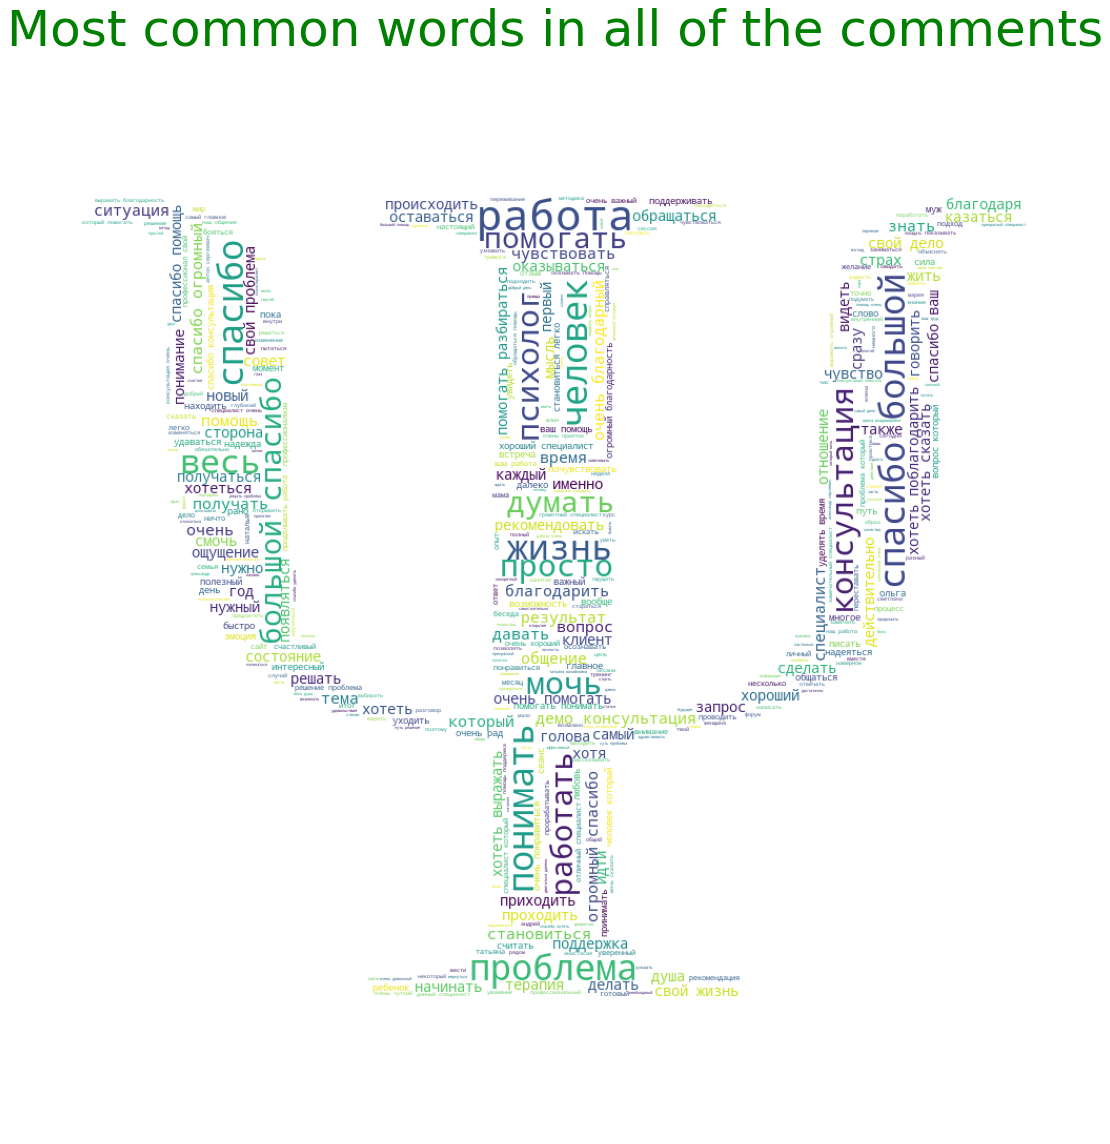

In [140]:
comments_text = ' '.join(all_words)
comments_mask = np.array(Image.open(d + 'psy.png'))
plot_wordcloud(comments_text, comments_mask, max_words=400, max_font_size=120, 
               title = 'Most common words in all of the comments', title_size=50)